In [2]:
import xarray as xr

In [3]:
ds = xr.open_dataset('/u/trappist-r0/govorcin/01_OPERA/HRES/delivery_data_tropo/input_data/D06130600061306001.zz.nc')

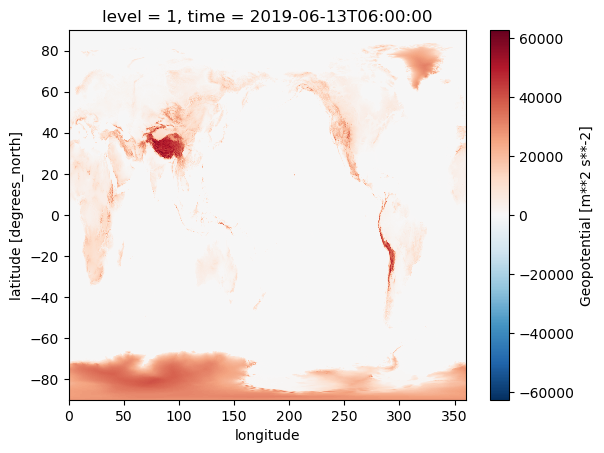

In [10]:
ds.z.isel(time=0, level=0).plot.imshow()